In [31]:
!nvidia-smi

Thu Oct 30 10:17:15 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   60C    P0             30W /   70W |     103MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# Import Libaries

In [32]:
!pip install lightning timm scikit-learn matplotlib seaborn
!pip install --upgrade pip
# === Imports ===
import os
import pandas as pd
import numpy as np
import timm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from PIL import Image
import lightning.pytorch as L
from lightning.pytorch import LightningModule, Trainer, LightningDataModule
from lightning.pytorch.callbacks import Callback
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Set Device

In [33]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f" Using device: {device}")

 Using device: cuda


# Data Paths 

In [34]:
train_df = pd.read_csv('/kaggle/input/ai-vs-human-generated-dataset/train.csv')
test_df  = pd.read_csv('/kaggle/input/ai-vs-human-generated-dataset/test.csv')
img_dir  = '/kaggle/input/ai-vs-human-generated-dataset/'


train_df['pair_id'] = train_df.index // 2
unique_pairs = train_df['pair_id'].unique()
train_pairs, val_pairs = train_test_split(unique_pairs, test_size=0.2, random_state=42, shuffle=True)
train_df_split = train_df[train_df['pair_id'].isin(train_pairs)].reset_index(drop=True)
val_df_split   = train_df[train_df['pair_id'].isin(val_pairs)].reset_index(drop=True)
print("Training samples:", len(train_df_split), "Validation samples:", len(val_df_split))

Training samples: 63960 Validation samples: 15990


# Data Transforms

In [35]:
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 2.0)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


# Custom Dataset Class

In [36]:
class CustomDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None, is_test=False):
        self.dataframe = dataframe
        self.img_dir = img_dir
        self.transform = transform
        self.is_test = is_test

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        if self.is_test:
            img_path = os.path.join(self.img_dir, self.dataframe.iloc[idx]['id'])
        else:
            img_path = os.path.join(self.img_dir, self.dataframe.iloc[idx]['file_name'])
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        if self.is_test:
            return image, self.dataframe.iloc[idx]['id']
        else:
            label = self.dataframe.iloc[idx]['label']
            return image, label


# Lightning DataModule with Train/Val Split

In [37]:
class ImageDataModule(LightningDataModule):
    def __init__(self, train_df, val_df, test_df, img_dir, batch_size=64):
        super().__init__()
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        self.img_dir = img_dir
        self.batch_size = batch_size
        self.test_dataset = None

    def setup(self, stage=None):
        if stage == 'fit' or stage is None:
            self.train_dataset = CustomDataset(self.train_df, self.img_dir, transform=train_transform)
            self.val_dataset   = CustomDataset(self.val_df, self.img_dir, transform=val_transform)
        if stage == 'test' or stage is None:
            self.test_dataset = CustomDataset(self.test_df, self.img_dir, transform=val_transform, is_test=True)

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=4)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False, num_workers=4)

    def test_dataloader(self):
        if self.test_dataset is None:
            self.setup(stage='test')
        return DataLoader(self.test_dataset, batch_size=self.batch_size, shuffle=False, num_workers=4)

# Metrics Callback (Fixed)

In [38]:
class MetricsCallback(Callback):
    def __init__(self):
        super().__init__()
        self.train_losses = []
        self.val_losses = []
        self.train_accs = []
        self.val_accs = []
        
    def on_train_epoch_end(self, trainer, pl_module):
        # Only store epoch-level metrics
        if 'train_loss_epoch' in trainer.callback_metrics:
            self.train_losses.append(trainer.callback_metrics['train_loss_epoch'].item())
        elif 'train_loss' in trainer.callback_metrics:
            self.train_losses.append(trainer.callback_metrics['train_loss'].item())
            
        if 'train_acc_epoch' in trainer.callback_metrics:
            self.train_accs.append(trainer.callback_metrics['train_acc_epoch'].item())
        elif 'train_acc' in trainer.callback_metrics:
            self.train_accs.append(trainer.callback_metrics['train_acc'].item())
            
    def on_validation_epoch_end(self, trainer, pl_module):
        # Only store epoch-level metrics
        if 'val_loss' in trainer.callback_metrics:
            self.val_losses.append(trainer.callback_metrics['val_loss'].item())
        if 'val_acc' in trainer.callback_metrics:
            self.val_accs.append(trainer.callback_metrics['val_acc'].item())


# **SqueezeNet Model**

In [39]:
class SqueezeNetClassifier(LightningModule):
    def __init__(self, num_classes=2, lr=1e-4):
        super().__init__()
        self.save_hyperparameters()
        self.model = models.squeezenet1_1(pretrained=True)
        self.model.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1, 1))
        self.loss_fn = nn.CrossEntropyLoss()
        
        self.val_preds = []
        self.val_targets = []

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self(images)
        loss = self.loss_fn(outputs, labels)
        preds = torch.argmax(outputs, dim=1)
        acc = (preds == labels).float().mean()
        self.log('train_loss', loss, prog_bar=True, on_step=False, on_epoch=True)
        self.log('train_acc', acc, prog_bar=True, on_step=False, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self(images)
        loss = self.loss_fn(outputs, labels)
        preds = torch.argmax(outputs, dim=1)
        acc = (preds == labels).float().mean()
        self.log('val_loss', loss, prog_bar=True, on_epoch=True)
        self.log('val_acc', acc, prog_bar=True, on_epoch=True)
        
        self.val_preds.extend(preds.cpu().numpy())
        self.val_targets.extend(labels.cpu().numpy())
        
        return loss
    
    def on_validation_epoch_end(self):
        if len(self.val_preds) > 0:
            cm = confusion_matrix(self.val_targets, self.val_preds)
            accuracy = accuracy_score(self.val_targets, self.val_preds)
            
            fig = plt.figure(figsize=(8, 6))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                       xticklabels=['AI', 'Human'], 
                       yticklabels=['AI', 'Human'])
            plt.title(f'Confusion Matrix - Accuracy: {accuracy:.4f}')
            plt.xlabel('Predicted')
            plt.ylabel('Actual')
            plt.tight_layout()
            
            if self.logger:
                self.logger.experiment.add_figure('Confusion Matrix', fig, self.current_epoch)
            plt.close()
            
            self.val_preds = []
            self.val_targets = []

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.hparams.lr)
        return optimizer

# Train Model 
With Checkpoints

In [40]:
# === Initialize DataModule ===
datamodule = ImageDataModule(train_df_split, val_df_split, test_df, img_dir, batch_size=64)

# === Initialize Model and Callbacks ===
model_squeezenet = SqueezeNetClassifier(num_classes=2)
metrics_callback = MetricsCallback()

trainer = Trainer(
    max_epochs=10,
    accelerator='auto',
    devices=1 if torch.cuda.is_available() else None,
    log_every_n_steps=10,
    callbacks=[metrics_callback]
)

print(" Starting SqueezeNet training...")
trainer.fit(model_squeezenet, datamodule)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
INFO: 
  | Name    | Type             | Params | Mode 
-----------------------------------------------------
0 | model   | SqueezeNet       | 723 K  | train
1 | loss_fn | CrossEntropyLoss | 0      | train
-----------------------------------------------------
723 K     Trainable params
0         Non-trainable params
723 K     Total params
2.894     Total estimated model params size (MB)
69        Modules in train mode
0         Modules in eval mode


 Starting SqueezeNet training...


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

# Plot Training History 

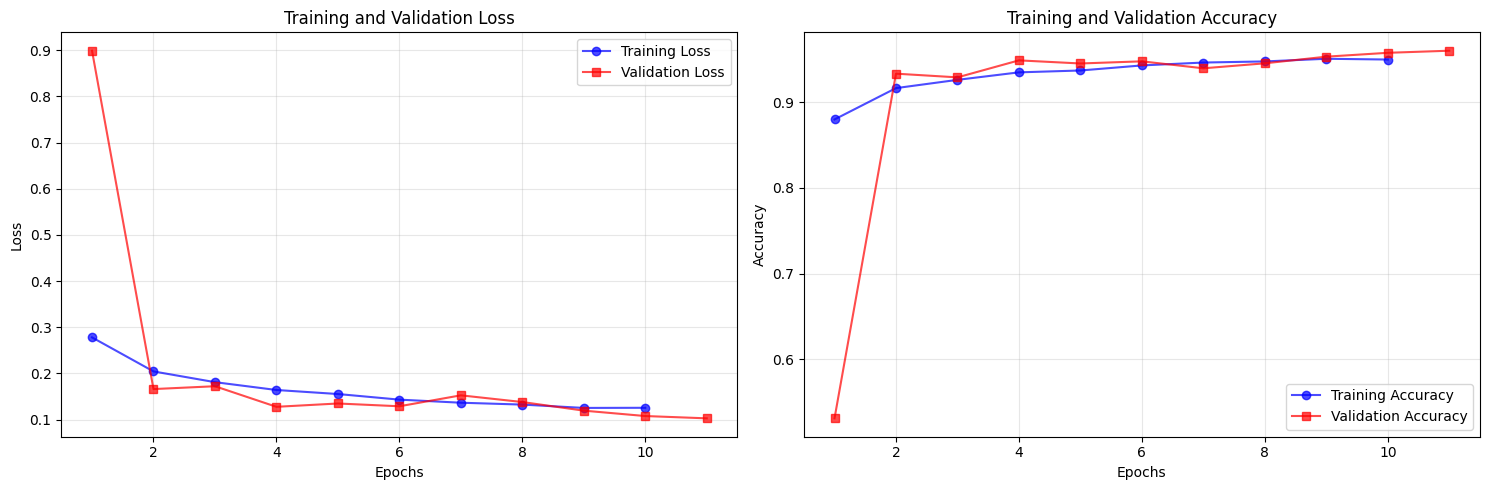


 Final Training Metrics:
   - Final Training Loss: 0.1257
   - Final Training Accuracy: 0.9497
   - Final Validation Loss: 0.1028
   - Final Validation Accuracy: 0.9600

 Running final validation with detailed metrics...


Validation: 100%|██████████| 250/250 [00:49<00:00,  5.08it/s]


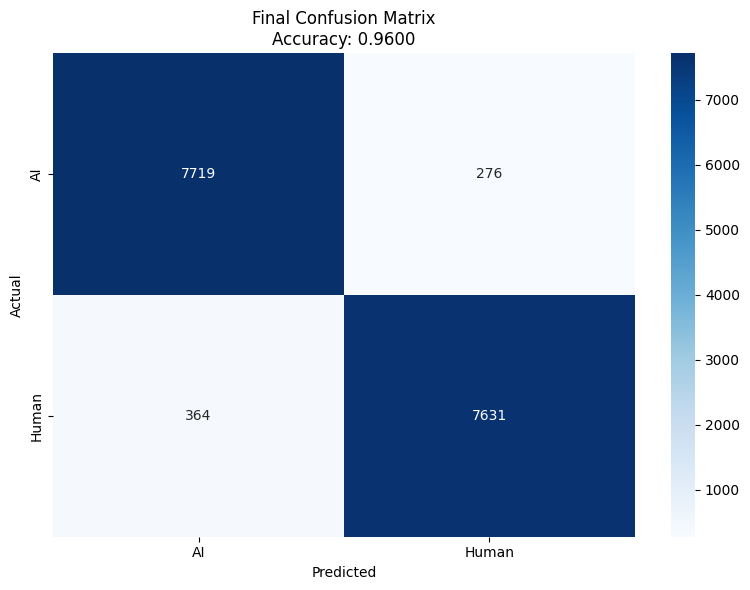


 Final Validation Results:
   - Accuracy: 0.9600
   - Confusion Matrix:
        7719 (AI→AI)    276 (AI→Human)
         364 (Human→AI) 7631 (Human→Human)

 Classification Report:
              precision    recall  f1-score   support

          AI       0.95      0.97      0.96      7995
       Human       0.97      0.95      0.96      7995

    accuracy                           0.96     15990
   macro avg       0.96      0.96      0.96     15990
weighted avg       0.96      0.96      0.96     15990



In [41]:
def plot_training_history(metrics_callback):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    epochs = range(1, len(metrics_callback.train_losses) + 1)
    
    # Plot losses
    ax1.plot(epochs, metrics_callback.train_losses, 'b-', label='Training Loss', alpha=0.7, marker='o')
    if len(metrics_callback.val_losses) > 0:
        val_epochs = range(1, len(metrics_callback.val_losses) + 1)
        ax1.plot(val_epochs, metrics_callback.val_losses, 'r-', label='Validation Loss', alpha=0.7, marker='s')
    ax1.set_title('Training and Validation Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot accuracies
    ax2.plot(epochs, metrics_callback.train_accs, 'b-', label='Training Accuracy', alpha=0.7, marker='o')
    if len(metrics_callback.val_accs) > 0:
        val_epochs = range(1, len(metrics_callback.val_accs) + 1)
        ax2.plot(val_epochs, metrics_callback.val_accs, 'r-', label='Validation Accuracy', alpha=0.7, marker='s')
    ax2.set_title('Training and Validation Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n Final Training Metrics:")
    if len(metrics_callback.train_losses) > 0:
        print(f"   - Final Training Loss: {metrics_callback.train_losses[-1]:.4f}")
        print(f"   - Final Training Accuracy: {metrics_callback.train_accs[-1]:.4f}")
    if len(metrics_callback.val_losses) > 0:
        print(f"   - Final Validation Loss: {metrics_callback.val_losses[-1]:.4f}")
        print(f"   - Final Validation Accuracy: {metrics_callback.val_accs[-1]:.4f}")

# Plot training history
if len(metrics_callback.train_losses) > 0:
    plot_training_history(metrics_callback)
else:
    print(" No training metrics recorded. Check callback implementation.")

# === Final Validation with Detailed Metrics ===
print("\n Running final validation with detailed metrics...")
model_squeezenet.eval()
model_squeezenet.to(device)  # Move model to device
all_preds = []
all_targets = []

datamodule.setup(stage='fit')

with torch.no_grad():
    for batch in tqdm(datamodule.val_dataloader(), desc="Validation"):
        images, labels = batch
        images = images.to(device)
        outputs = model_squeezenet(images)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(labels.cpu().numpy())

# Calculate final confusion matrix and metrics
final_cm = confusion_matrix(all_targets, all_preds)
final_accuracy = accuracy_score(all_targets, all_preds)
classification_rep = classification_report(all_targets, all_preds, target_names=['AI', 'Human'])

# Plot final confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(final_cm, annot=True, fmt='d', cmap='Blues', 
           xticklabels=['AI', 'Human'], 
           yticklabels=['AI', 'Human'])
plt.title(f'Final Confusion Matrix\nAccuracy: {final_accuracy:.4f}')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

print(f"\n Final Validation Results:")
print(f"   - Accuracy: {final_accuracy:.4f}")
print(f"   - Confusion Matrix:")
print(f"        {final_cm[0][0]:>4} (AI→AI)   {final_cm[0][1]:>4} (AI→Human)")
print(f"        {final_cm[1][0]:>4} (Human→AI) {final_cm[1][1]:>4} (Human→Human)")
print(f"\n Classification Report:")
print(classification_rep)

#  Test Predictions

In [42]:
print("\n🔮 Making test predictions...")
test_predictions = []
test_ids = []

datamodule.setup(stage='test')
model_squeezenet.to(device)  # Ensure model is on device

with torch.no_grad():
    for batch in tqdm(datamodule.test_dataloader(), desc="Test Predictions"):
        images, ids = batch
        images = images.to(device)
        outputs = model_squeezenet(images)
        preds = torch.argmax(outputs, dim=1)
        test_predictions.extend(preds.cpu().numpy())
        test_ids.extend(ids)




🔮 Making test predictions...


Test Predictions: 100%|██████████| 87/87 [01:08<00:00,  1.28it/s]


# Create Submission File

In [43]:
submission_df = pd.DataFrame({
    'id': test_ids,
    'label': test_predictions
})

submission_df.to_csv('squeezenet_submission.csv', index=False)
print(" Submission file saved as 'squeezenet_submission.csv'")

test_ai_count = sum(test_predictions)
test_human_count = len(test_predictions) - test_ai_count
print(f"\n Test Set Predictions Distribution:")
print(f"   - AI Generated: {test_ai_count} samples ({test_ai_count/len(test_predictions)*100:.1f}%)")
print(f"   - Human Generated: {test_human_count} samples ({test_human_count/len(test_predictions)*100:.1f}%)")
print(f" Submission preview:\n{submission_df.head()}")

print("\n SqueezeNet training and evaluation completed!")

 Submission file saved as 'squeezenet_submission.csv'

 Test Set Predictions Distribution:
   - AI Generated: 1105 samples (19.9%)
   - Human Generated: 4435 samples (80.1%)
 Submission preview:
                                                  id  label
0  test_data_v2/1a2d9fd3e21b4266aea1f66b30aed157.jpg      0
1  test_data_v2/ab5df8f441fe4fbf9dc9c6baae699dc7.jpg      0
2  test_data_v2/eb364dd2dfe34feda0e52466b7ce7956.jpg      0
3  test_data_v2/f76c2580e9644d85a741a42c6f6b39c0.jpg      0
4  test_data_v2/a16495c578b7494683805484ca27cf9f.jpg      0

 SqueezeNet training and evaluation completed!
